In [120]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os


In [130]:
xy = np.load("feri_ds.npz")
X_train, X_test, y_train, y_test = xy["X_train"], xy["X_test"], xy["y_train"], xy["y_test"]

In [131]:
X_train.shape

(28709, 48, 48)

In [132]:
X_test.shape

(7178, 48, 48)

In [133]:
X_train[indices_to_remove]

array([[[119,  95, 150, ...,  99, 170, 216],
        [101, 126, 162, ..., 113, 130, 179],
        [114, 143, 174, ..., 153, 120, 130],
        ...,
        [ 92,  90,  75, ..., 120, 139,  94],
        [114,  97, 113, ...,  92, 117, 121],
        [160, 108, 102, ...,  87,  81, 105]],

       [[102, 104, 103, ...,  91,  90,  92],
        [102, 103, 101, ...,  91,  91,  93],
        [102, 102, 100, ...,  81,  93,  90],
        ...,
        [ 61,  67,  71, ...,  36,  35,  36],
        [ 62,  69,  63, ...,  33,  33,  36],
        [ 57,  71,  60, ...,  45,  28,  33]],

       [[172, 169, 164, ..., 181, 188, 189],
        [171, 166, 168, ..., 174, 189, 187],
        [178, 171, 168, ..., 182, 174, 189],
        ...,
        [143, 140, 136, ...,  49,  44,  50],
        [138, 136, 132, ...,  40,  38,  30],
        [135, 133, 129, ...,  52,  36,  32]],

       ...,

       [[160, 163, 159, ...,  87,  62,  68],
        [148, 145, 141, ...,  84,  70,  72],
        [133, 133, 128, ...,  90,  75,  57

In [134]:
print(X_train.shape)
print(X_test.shape)

(28709, 48, 48)
(7178, 48, 48)


In [128]:
# upon investigating the dataset, I found some images that were simply blank (black). I've removed them (along with images that may be too dark) here, hoping it will help model performance
intensity_threshold = 25

X_train_mean = np.mean(X_train, axis=(1,2))
X_test_mean = np.mean(X_test, axis=(1,2))

train_indices_to_remove = np.where(X_train_mean < intensity_threshold)
test_indices_to_remove = np.where(X_test_mean < intensity_threshold)

X_train_filtered = np.delete(X_train, train_indices_to_remove, axis=0)
y_train_filtered = np.delete(y_train, train_indices_to_remove)

X_test_filtered = np.delete(X_test, test_indices_to_remove, axis=0)
y_test_filtered = np.delete(y_test, test_indices_to_remove)

print("removed indices (train):", train_indices_to_remove)
print("removed indices (test):", test_indices_to_remove)

print("\nnew X_train:", X_train_filtered.shape)
print("new y_train:", y_train_filtered.shape)
print("\nnew X_test", X_test_filtered.shape)
print("new y_test:", y_test_filtered.shape)

removed indices (train): (array([    2,   690,   838,  1002,  1796,  1882,  2062,  3006,  3846,
        3965,  4823,  6919,  9310, 14749, 17309, 20062, 20112, 20410,
       22795, 24580, 24615, 25066, 26879]),)
removed indices (test): (array([ 716, 2453, 3085, 3892, 4864, 6142, 6158, 6977]),)

new X_train: (28686, 48, 48)
new y_train: (28686,)

new X_test (7170, 48, 48)
new y_test: (7170,)


In [135]:
from sklearn.utils import shuffle
X_train_filtered, y_train_filtered = shuffle(X_train_filtered, y_train_filtered)
X_test_filtered, y_test_filtered = shuffle(X_test_filtered, y_test_filtered)

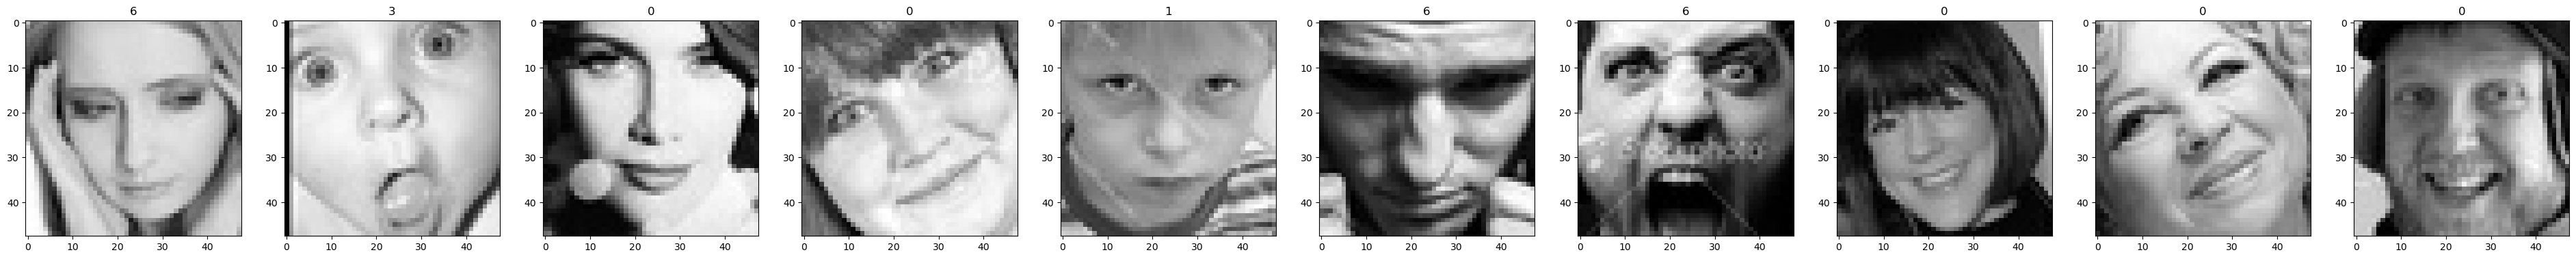

In [136]:
fig, axs = plt.subplots(1,10, figsize=(48, 48))

for i in range(10):
    axs[i].imshow(X_train_filtered[i], cmap="gray")
    axs[i].set_title(y_train_filtered[i])

In [137]:
labels = {
    "happy": 0,
    "sad": 1,
    "neutral": 2,
    "surprise": 3,
    "angry": 4,
    "disgust": 5,
    "fear": 6
    }

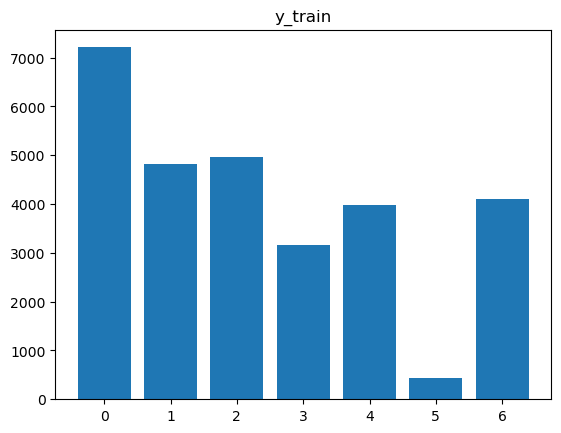

In [138]:
import matplotlib.pyplot as plt

def plot_values(data, title):
    values, counts = np.unique(data, return_counts=True)
    plt.bar(values, counts)
    plt.title(title)
    plt.show()

plot_values(y_train_filtered, "y_train")

In [139]:
X_train_scaled = X_train_filtered / 255.0
X_test_scaled = X_test_filtered / 255.0

In [140]:
# one-hot encoding
y_train_ohe = tf.one_hot(y_train_filtered, depth=7)
y_test_ohe = tf.one_hot(y_test_filtered, depth=7)

In [141]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [145]:
import keras
from keras import layers

reg = tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)

cnn_model = keras.Sequential([
    layers.Conv2D(64, (5,5), (1,1), activation = "relu", input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2], 1), padding = "same", kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation = "relu", kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(5120, activation="relu", kernel_regularizer=reg),
    layers.Dropout(0.2),
    layers.Dense(1024, activation="relu", kernel_regularizer=reg),
    layers.Dense(512, activation="relu", kernel_regularizer=reg),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu", kernel_regularizer=reg),
    layers.Dense(64, activation="relu", kernel_regularizer=reg),
    layers.Dropout(0.2),
    layers.Dense(7, activation="softmax"),
])


cnn_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 5120)           │    39,654,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1024)           │     5,243,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,536,583 (173.71 MB)

 Trainable params: 45,536,327 (173.71 MB)

 Non-trainable params: 256 (1.00 KB)

In [146]:
loss = tf.keras.losses.CategoricalCrossentropy()

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  loss=loss,
  metrics=["accuracy"])

In [147]:
cnn_model.fit(X_train_scaled, y_train_ohe, epochs=10, validation_split=0.2, shuffle=True, batch_size=64)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.2761 - loss: 7.9069 - val_accuracy: 0.3174 - val_loss: 7.3599
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - accuracy: 0.4099 - loss: 6.9521 - val_accuracy: 0.4397 - val_loss: 6.3328
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - accuracy: 0.4803 - loss: 6.0628 - val_accuracy: 0.4559 - val_loss: 5.5927
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.5538 - loss: 5.2117 - val_accuracy: 0.4883 - val_loss: 4.9779
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.6476 - loss: 4.4888 - val_accuracy: 0.5162 - val_loss: 4.5457
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.7575 - loss: 3.8538 - val_accuracy: 0.5261 - val_loss: 4.4340
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.8640 - loss: 3.3555 - val_accuracy: 0.5267 - val_loss: 4.2898
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.9277 - loss: 3.

In [155]:
cnn_model.evaluate(X_test_scaled, y_test_ohe)

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5205 - loss: 4.5030


[4.488467216491699, 0.5253835320472717]